In [1]:
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from scipy import stats

<b> Produces the Transfer and Native Student DataFrames for the given category:</b>

In [144]:
def scaled_categories(reflections, category, label, x, scale1, scale5):
    categoryIssue = 0
    for i in range(x):
        reflections[i][category] = reflections[i][category].replace(to_replace = scale1, value = 1)
        reflections[i][category] = reflections[i][category].replace(to_replace = "2", value = 2)
        reflections[i][category] = reflections[i][category].replace(to_replace = "3", value = 3)
        reflections[i][category] = reflections[i][category].replace(to_replace = "4", value = 4)    
        reflections[i][category] = reflections[i][category].replace(to_replace = scale5, value = 5)
        category_issue = reflections[i][category]
        DeID = reflections[i]["DeID"]
        s = label + str(i) 
        cat = DataFrame({"DeID": DeID, s: category_issue})
        if i == 0:
            categoryIssue = cat
        else:
            categoryIssue = pd.merge(categoryIssue, cat, on="DeID")
            
    df = pd.read_csv("CSE 11 Fall 2019 DeID\\DeID Pre-Survey CSE 11 Fall 2019.csv")
    status = df["Did.you.enter.UCSD.as.a.transfer.student.from.another..2.year.or.4.year..college.or.university."] == "Yes"
    DeID = df["DeID"]
    transferStatus = DataFrame({"DeID": DeID, "Transfer Status": status})

    mergedData = pd.merge(transferStatus, categoryIssue, on="DeID")
    transfer = mergedData[mergedData["Transfer Status"] == True]
    native = mergedData[mergedData["Transfer Status"] == False]
    
    return {'transfer' : transfer, 'native' : native}
    
        

<b> Produces the Diverging Graph Plot : </b>

In [145]:
def DivergingGraphPlot(transfer, native, label, graphTitle, X_title, Y_title):
    transferDistribution = [0,0,0,0,0]
    nativeDistribution = [0,0,0,0,0]
    for i in transfer.index:
        for j in transfer:
            if(j == "DeID" or j == "Transfer Status"):
                continue
            transferDistribution[int(transfer[j][i])-1] += 1;

    for i in native.index:
        for j in native:
            if(j == "DeID" or j == "Transfer Status"):
                continue
            nativeDistribution[int(native[j][i])-1] += 1;
    
    sumN = sum(nativeDistribution)
    sumT = sum(transferDistribution)
    for i in range(5):
        nativeDistribution[i] /= sumN/100
        transferDistribution[i] /= sumT/100
    
    d = {
    'Who' : ["Transfer", "Native"],
    '1 (Not at all)' : [transferDistribution[0],nativeDistribution[0]],
    '2' : [transferDistribution[1],nativeDistribution[1]],
    '3' : [transferDistribution[2],nativeDistribution[2]],
    '4' : [transferDistribution[3],nativeDistribution[3]],
    '5 (Significantly)' :[transferDistribution[4],nativeDistribution[4]]
    }
    df = pd.DataFrame(d)

    fig = go.Figure()
    for col in df.columns[1:]:
        fig.add_trace(go.Bar(x= df[col],
                             y =df['Who'],
                             orientation='h',
                             name= col,
                             hovertemplate="%{y}: %{x}"))    

    fig.update_layout(title=graphTitle,
                      xaxis_title=X_title,
                      yaxis_title=Y_title,
                      legend_title="Scale",
                      barmode='relative', 
                      height=400, 
                      width=700, 
                      yaxis_autorange='reversed',
                      bargap=0.01,
                      legend_orientation ='h',
                      legend_x=0.05, legend_y=1.2
                     )
    
    return fig

<b> Produces Box Plots and Removes Outliers </b>

In [202]:
def OutlierLineGraph(transfer, native, label, graphTitle, X_title, Y_title, x_label, x):         
    transferIssues = []
    nativeIssues = []
    difference = []
    ttestStatistics = []
    pValuesT = []
    utestStatistics = []
    pValuesU = []
    for i in range(x):
        df = pd.DataFrame({label+str(i):transfer[label+str(i)]})
        df['z_score']=stats.zscore(transfer[label+str(i)])
        df = df[df['z_score'].abs()<=3]
        transferRefined = df[df[label+str(i)] >= 0]
        
        df = pd.DataFrame({label+str(i):native[label+str(i)]})
        df['z_score']=stats.zscore(native[label+str(i)])
        df = df[df['z_score'].abs()<=3]
        nativeRefined = df[df[label+str(i)] >= 0]
        
        if(i == 0 or i == x-1):
            data = [transfer[label+str(i)], native[label+str(i)]]
            
            fig = plt.figure(figsize =(10, 7)) 
            ax = fig.add_subplot(111) 
            bp = ax.boxplot(data, patch_artist = True, notch ='True', vert = 0)
            
            colors = ['#0000FF', '#00FF00']
            for patch, color in zip(bp['boxes'], colors): 
                patch.set_facecolor(color) 
                
            # changing color and linewidth of 
            # whiskers 
            for whisker in bp['whiskers']: 
                whisker.set(color ='#8B008B', 
                            linewidth = 1.5, 
                            linestyle =":") 

            # changing color and linewidth of 
            # caps 
            for cap in bp['caps']: 
                cap.set(color ='#8B008B', 
                        linewidth = 2) 

            # changing color and linewidth of 
            # medians 
            for median in bp['medians']: 
                median.set(color ='red', 
                           linewidth = 3) 

            # changing style of fliers 
            for flier in bp['fliers']: 
                flier.set(marker ='D', 
                          color ='#e7298a', 
                          alpha = 0.5) 

            # x-axis labels 
            ax.set_yticklabels(['Transfer', 'Native']) 

            # Adding title  
            plt.title("Week " + str(i+2) + " Box Plot" ) 

            # Removing top axes and right axes 
            # ticks 
            ax.get_xaxis().tick_bottom() 
            ax.get_yaxis().tick_left() 
            
            plt.xlim(-6, 30)

            # show plot 
            plt.show(bp) 
        
        transferIssues.append(transferRefined[label+str(i)].mean())
        nativeIssues.append(nativeRefined[label+str(i)].mean())
        difference.append(transferIssues[i] - nativeIssues[i])
        ttest_results = stats.ttest_ind(transferRefined[label+str(i)], nativeRefined[label+str(i)])
        utest_results = stats.mannwhitneyu(transferRefined[label+str(i)], nativeRefined[label+str(i)])
        ttestStatistics.append(ttest_results[0])
        pValuesT.append(ttest_results[1])
        utestStatistics.append(utest_results[0])
        pValuesU.append(utest_results[1])
        
    df = DataFrame({"Week" : Series(x_label), 
                    "Transfer Mean" : Series(transferIssues), 
                    "Native Mean" : Series(nativeIssues), 
                    "Difference" : difference, 
                    "p-value (t-test)" : pValuesT,
                    "p-value (u-test)" : pValuesU,
                    "Test Statistic (t-test)" : ttestStatistics,
                    "Test Statistic (u-test)" : utestStatistics})
    
    
    plt.plot(x_label, transferIssues, "-ok", color='blue')
    plt.plot(x_label, nativeIssues, "-ok", color='green')
    plt.legend(['transfers','natives'])
    plt.suptitle(graphTitle, fontsize=14)
    plt.xlabel(X_title, fontsize=10)
    plt.ylabel(Y_title, fontsize=10)
    
    return df


<b> Produces the Line Graph: </b>

In [195]:
def plotLineGraph(transfer, native, label, graphTitle, X_title, Y_title, x_label, x):
    transferIssues = []
    nativeIssues = []
    difference = []
    ttestStatistics = []
    pValuesT = []
    utestStatistics = []
    pValuesU = []
    for i in range(x):
        transferIssues.append(transfer[label+str(i)].mean())
        nativeIssues.append(native[label+str(i)].mean())
        difference.append(transferIssues[i] - nativeIssues[i])
        ttest_results = stats.ttest_ind(transfer[label+str(i)], native[label+str(i)])
        utest_results = stats.mannwhitneyu(transfer[label+str(i)], native[label+str(i)])
        ttestStatistics.append(ttest_results[0])
        pValuesT.append(ttest_results[1])
        utestStatistics.append(utest_results[0])
        pValuesU.append(utest_results[1])
        
    df = DataFrame({"Week" : Series(x_label), 
                    "Transfer Mean" : Series(transferIssues), 
                    "Native Mean" : Series(nativeIssues), 
                    "Difference" : difference, 
                    "p-value (t-test)" : pValuesT,
                    "p-value (u-test)" : pValuesU,
                    "Test Statistic (t-test)" : ttestStatistics,
                    "Test Statistic (u-test)" : utestStatistics})
    
    
    plt.plot(x_label, transferIssues, "-ok", color='blue')
    plt.plot(x_label, nativeIssues, "-ok", color='green')
    plt.ylim(0.5, 5.5)
    plt.legend(['transfers','natives'])
    plt.suptitle(graphTitle, fontsize=14)
    plt.xlabel(X_title, fontsize=10)
    plt.ylabel(Y_title, fontsize=10)
    
    return df

<h1> CSE 11: </h1>

In [196]:
reflections = []
for i in range (2,10):
    reflections.append(pd.read_csv(r"CSE 11 Fall 2019 DeID\DeID Weekly Reflection (CSE 11 PA" +str(i)+").csv"))

<h3>People You Feel Comfortable Reaching Out to:</h3>

In [203]:
category = "At.this.time..approximately.how.many.other.students.in.this.course.would.you.be.comfortable.reaching.out.to.study.with."
label = "# of People "
graphTitle = "# of People you Feel Comfortable Reaching Out To"
X_title = "Percentage"
Y_title = "Student Type"
x = 8
scale1 = "1"
scale5 = "5"
data = scaled_categories(reflections, category, label, x, scale1, scale5)
transfer = data['transfer']
native = data['native']

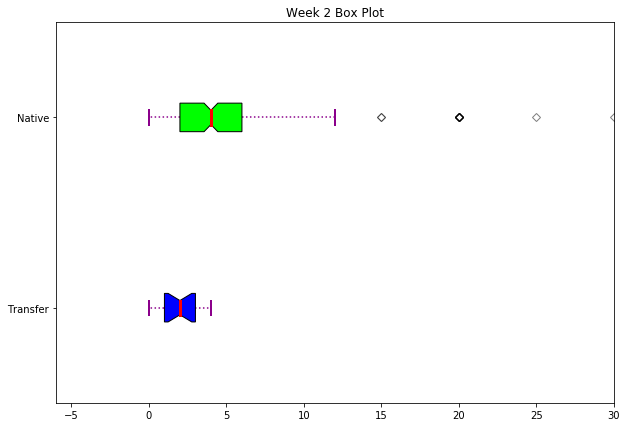

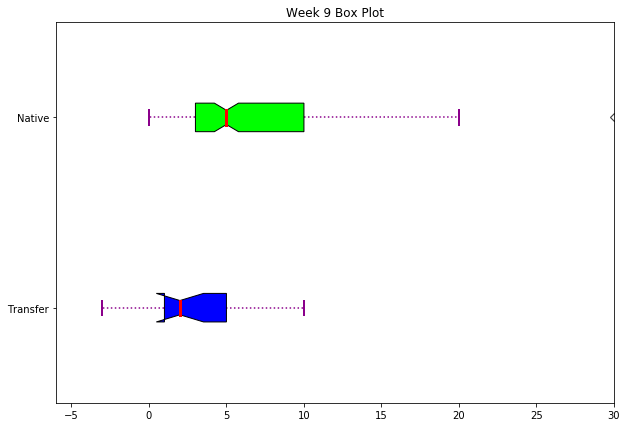

     Week  Transfer Mean  Native Mean  Difference  p-value (t-test)  \
0  Week 2       1.812500     5.664975   -3.852475          0.029587   
1  Week 3       2.125000     5.863636   -3.738636          0.039087   
2  Week 4       2.062500     6.291457   -4.228957          0.025828   
3  Week 5       2.187500     6.335025   -4.147525          0.012478   
4  Week 6       2.200000     6.010204   -3.810204          0.003656   
5  Week 7       2.333333     6.204082   -3.870748          0.004064   
6  Week 8       2.533333     6.385787   -3.852453          0.006794   
7  Week 9       3.375000     6.301020   -2.926020          0.029389   

   p-value (u-test)  Test Statistic (t-test)  Test Statistic (u-test)  
0          0.000172                -2.190450                    734.5  
1          0.000300                -2.076135                    774.0  
2          0.000145                -2.244500                    731.0  
3          0.000075                -2.519947                    683.5  


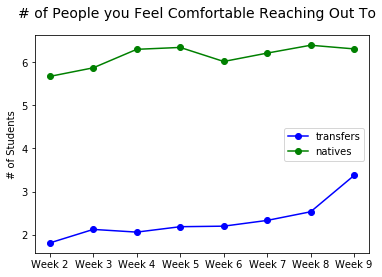

In [204]:
X_label = ""
Y_label = "# of Students"
x_label = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
graphLabel = "# of People you Feel Comfortable Reaching Out To"
df = OutlierLineGraph(transfer, native, label, graphLabel, X_label, Y_label, x_label, x)
print(df)

<h3>Social/Personal Life Issues:</h3>

In [151]:
category = "In.the.past.week..on.a.scale.of.1.to.5..to.what.degree.did.each.of.the.following.interfere.with.your.ability.to.learn.and.complete.the.work.for.this.course..Social.personal.life.issues."
label = "Social/Personal Life Issues"
graphTitle = "Social/Personal Life effects on Learning"
X_title = "Percentage"
Y_title = "Student Type"
x = 8
scale1 = "1 (Not at all)"
scale5 = "5 (Significantly)"
data = scaled_categories(reflections, category, label, x, scale1, scale5)
transfer = data['transfer']
native = data['native']

     Week  Transfer Mean  Native Mean  Difference  p-value (t-test)  \
0  Week 2       2.058824        1.645    0.413824          0.078625   
1  Week 3       1.823529        1.605    0.218529          0.366293   
2  Week 4       1.882353        1.550    0.332353          0.168886   
3  Week 5       1.470588        1.485   -0.014412          0.948326   
4  Week 6       2.235294        1.490    0.745294          0.001690   
5  Week 7       1.941176        1.410    0.531176          0.014146   
6  Week 8       1.882353        1.510    0.372353          0.160710   
7  Week 9       1.705882        1.430    0.275882          0.232111   

   p-value (u-test)  Test Statistic (t-test)  Test Statistic (u-test)  
0          0.063278                 1.767128                   1360.0  
1          0.055846                 0.905350                   1356.5  
2          0.160814                 1.380437                   1494.0  
3          0.464516                -0.064885                   1682.0  


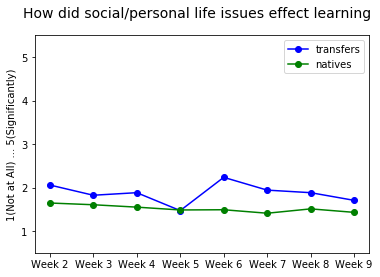

In [152]:
fig = DivergingGraphPlot(transfer, native, label, graphTitle, X_title, Y_title)
fig.show()

X_label = ""
Y_label = "1(Not at All) ... 5(Significantly)"
x_label = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
graphLabel = "How did social/personal life issues effect learning"
df = plotLineGraph(transfer, native, label, graphLabel, X_label, Y_label, x_label, x)
print(df)

<h3> Embarassment/Discomfort Asking for Help: </h3>

In [205]:
category = "In.the.past.week..on.a.scale.of.1.to.5..to.what.degree.did.each.of.the.following.interfere.with.your.ability.to.learn.and.complete.the.work.for.this.course..Embarrassment.discomfort.asking.others.for.help."
label = "Embarassment/Discomfort"
graphTitle = "Embarrassment/Discomfort Asking for Help"
X_title = "Percentage"
Y_title = "Student Type"
x = 8
scale1 = "1 (Not at all)"
scale5 = "5 (Significantly)"
data = scaled_categories(reflections, category, label, x, scale1, scale5)
transfer = data['transfer']
native = data['native']

     Week  Transfer Mean  Native Mean  Difference  p-value (t-test)  \
0  Week 2       1.647059        1.300    0.347059          0.076282   
1  Week 3       1.764706        1.345    0.419706          0.045226   
2  Week 4       1.411765        1.205    0.206765          0.203994   
3  Week 5       1.117647        1.255   -0.137353          0.401033   
4  Week 6       1.294118        1.160    0.134118          0.317698   
5  Week 7       1.411765        1.160    0.251765          0.088655   
6  Week 8       1.411765        1.200    0.211765          0.165779   
7  Week 9       1.117647        1.155   -0.037353          0.779764   

   p-value (u-test)  Test Statistic (t-test)  Test Statistic (u-test)  
0          0.030971                 1.781257                   1383.0  
1          0.143974                 2.014282                   1509.5  
2          0.250207                 1.274126                   1602.0  
3          0.143771                -0.841446                   1534.5  


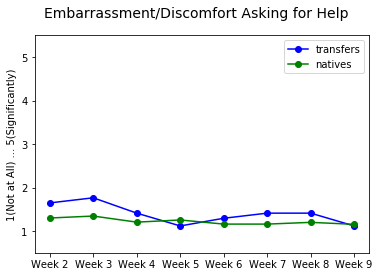

In [206]:
fig = DivergingGraphPlot(transfer, native, label, graphTitle, X_title, Y_title)
fig.show()

X_label = ""
Y_label = "1(Not at All) ... 5(Significantly)"
x_label = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
graphLabel = "Embarrassment/Discomfort Asking for Help"
df = plotLineGraph(transfer, native, label, graphLabel, X_label, Y_label, x_label, x)
print(df)

<h3>Work Obligations:</h3>

In [155]:
category = "In.the.past.week..on.a.scale.of.1.to.5..to.what.degree.did.each.of.the.following.interfere.with.your.ability.to.learn.and.complete.the.work.for.this.course..Work.obligations."
label = "Work Obligation"
graphTitle = "Work Obligation"
X_title = "Percentage"
Y_title = "Student Type"
x = 8
scale1 = "1 (Not at all)"
scale5 = "5 (Significantly)"
data = scaled_categories(reflections, category, label, x, scale1, scale5)
transfer = data['transfer']
native = data['native']

     Week  Transfer Mean  Native Mean  Difference  p-value (t-test)  \
0  Week 2       1.647059        1.155    0.492059          0.001234   
1  Week 3       1.411765        1.160    0.251765          0.084314   
2  Week 4       1.411765        1.200    0.211765          0.220653   
3  Week 5       1.764706        1.190    0.574706          0.000606   
4  Week 6       1.705882        1.210    0.495882          0.005369   
5  Week 7       1.529412        1.200    0.329412          0.038420   
6  Week 8       1.588235        1.205    0.383235          0.045902   
7  Week 9       1.470588        1.250    0.220588          0.254815   

   p-value (u-test)  Test Statistic (t-test)  Test Statistic (u-test)  
0          0.006248                 3.274298                   1355.5  
1          0.042145                 1.734210                   1466.0  
2          0.166444                 1.228364                   1568.5  
3          0.009054                 3.480658                   1357.5  


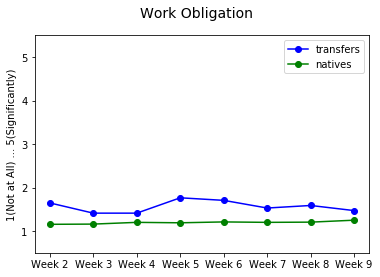

In [156]:
fig = DivergingGraphPlot(transfer, native, label, graphTitle, X_title, Y_title)
fig.show()

X_label = ""
Y_label = "1(Not at All) ... 5(Significantly)"
x_label = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
graphLabel = "Work Obligation"
df = plotLineGraph(transfer, native, label, graphLabel, X_label, Y_label, x_label, x)
print(df)

<h3> Inability to Get Help:</h3>

In [207]:
category = "In.the.past.week..on.a.scale.of.1.to.5..to.what.degree.did.each.of.the.following.interfere.with.your.ability.to.learn.and.complete.the.work.for.this.course..Inability.to.get.help."
label = "Help"
graphTitle = "Did you feel an Inability to get help?"
X_title = "Percentage"
Y_title = "Student Type"
x = 8
scale1 = "1 (Not at all)"
scale5 = "5 (Significantly)"
data = scaled_categories(reflections, category, label, x, scale1, scale5)
transfer = data['transfer']
native = data['native']

     Week  Transfer Mean  Native Mean  Difference  p-value (t-test)  \
0  Week 2       1.411765        1.240    0.171765          0.249679   
1  Week 3       1.352941        1.285    0.067941          0.685623   
2  Week 4       1.235294        1.145    0.090294          0.439824   
3  Week 5       1.176471        1.215   -0.038529          0.780482   
4  Week 6       1.352941        1.170    0.182941          0.212495   
5  Week 7       1.411765        1.145    0.266765          0.055962   
6  Week 8       1.352941        1.230    0.122941          0.487583   
7  Week 9       1.176471        1.145    0.031471          0.790739   

   p-value (u-test)  Test Statistic (t-test)  Test Statistic (u-test)  
0          0.107973                 1.154251                   1492.0  
1          0.340626                 0.405350                   1628.0  
2          0.203778                 0.773928                   1585.5  
3          0.338226                -0.279040                   1634.0  


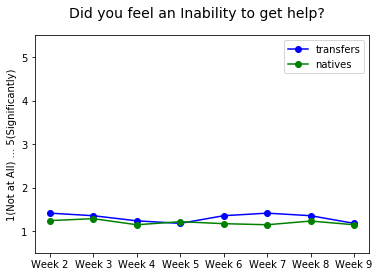

In [208]:
fig = DivergingGraphPlot(transfer, native, label, graphTitle, X_title, Y_title)
fig.show()

X_label = ""
Y_label = "1(Not at All) ... 5(Significantly)"
x_label = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
graphLabel = "Did you feel an Inability to get help?"
df = plotLineGraph(transfer, native, label, graphLabel, X_label, Y_label, x_label, x)
print(df)

<h2>Reflecting on your experiences over the past week, to what extent do you agree with the following statements</h2>


<h3>Sense of Belonging:</h3>

In [159]:
category = "Reflecting.on.your.experiences.over.the.past.week..to.what.extent.do.you.agree.with.the.following.statements..I.feel.like.I.don.t.belong.in.this.class.."
label = "Belonging"
graphTitle = "Don't Feel Like I Belong"
X_title = "Percentage"
Y_title = "Student Type"
x = 8
scale1 = "1 (Not at all)"
scale5 = "5 (Completely)"
data = scaled_categories(reflections, category, label, x, scale1, scale5)
transfer = data['transfer']
native = data['native']

     Week  Transfer Mean  Native Mean  Difference  p-value (t-test)  \
0  Week 2       1.705882        1.655    0.050882          0.849835   
1  Week 3       1.764706        1.750    0.014706          0.961783   
2  Week 4       1.647059        1.770   -0.122941          0.685346   
3  Week 5       2.117647        1.785    0.332647          0.297320   
4  Week 6       1.882353        1.780    0.102353          0.738600   
5  Week 7       1.823529        1.705    0.118529          0.687683   
6  Week 8       2.176471        1.680    0.496471          0.109778   
7  Week 9       1.823529        1.685    0.138529          0.656359   

   p-value (u-test)  Test Statistic (t-test)  Test Statistic (u-test)  
0          0.377324                 0.189557                   1632.5  
1          0.498131                 0.047973                   1698.5  
2          0.486926                -0.405728                   1692.5  
3          0.101006                 1.044731                   1425.0  


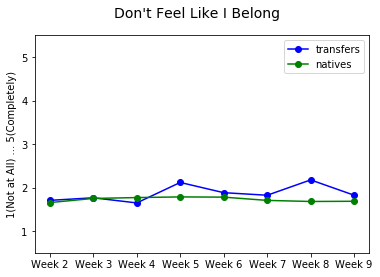

In [160]:
fig = DivergingGraphPlot(transfer, native, label, graphTitle, X_title, Y_title)
fig.show()

X_label = ""
Y_label = "1(Not at All) ... 5(Completely)"
x_label = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
graphLabel = "Don't Feel Like I Belong"
df = plotLineGraph(transfer, native, label, graphLabel, X_label, Y_label, x_label, x)
print(df)

<h3> Accepted in Class: </h3>

In [161]:
category = "Reflecting.on.your.experiences.over.the.past.week..to.what.extent.do.you.agree.with.the.following.statements..I.feel.accepted.in.this.class.."
label = "Accepted "
graphTitle = "How Accepted Do You Feel in Class"
X_title = "Percentage"
Y_title = "Student Type"
x = 8
scale1 = "1 (Not at all)"
scale5 = "5 (Completely)"
data = scaled_categories(reflections, category, label, x, scale1, scale5)
transfer = data['transfer']
native = data['native']

     Week  Transfer Mean  Native Mean  Difference  p-value (t-test)  \
0  Week 2       3.941176        4.220   -0.278824          0.220250   
1  Week 3       3.823529        4.280   -0.456471          0.037853   
2  Week 4       4.117647        4.275   -0.157353          0.491493   
3  Week 5       4.117647        4.305   -0.187353          0.385177   
4  Week 6       3.764706        4.260   -0.495294          0.039992   
5  Week 7       3.882353        4.310   -0.427647          0.063116   
6  Week 8       4.058824        4.330   -0.271176          0.240948   
7  Week 9       4.000000        4.330   -0.330000          0.170765   

   p-value (u-test)  Test Statistic (t-test)  Test Statistic (u-test)  
0          0.183609                -1.229441                   1491.5  
1          0.036633                -2.089351                   1289.0  
2          0.212247                -0.689116                   1518.0  
3          0.237858                -0.870171                   1538.0  


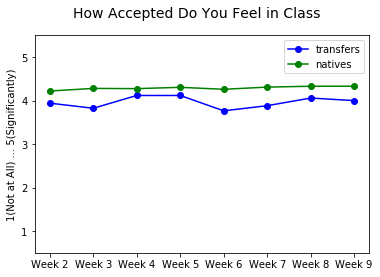

In [162]:
fig = DivergingGraphPlot(transfer, native, label, graphTitle, X_title, Y_title)
fig.show()

X_label = ""
Y_label = "1(Not at All) ... 5(Significantly)"
x_label = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
graphLabel = "How Accepted Do You Feel in Class"
df = plotLineGraph(transfer, native, label, graphLabel, X_label, Y_label, x_label, x)
print(df)

<h3>Comfortable in Class:</h3>

In [163]:
category = "Reflecting.on.your.experiences.over.the.past.week..to.what.extent.do.you.agree.with.the.following.statements..I.feel.comfortable.in.this.class.."
label = "Comfortable "
graphTitle = "How Comfortable Do You Feel in Class"
X_title = "Percentage"
Y_title = "Student Type"
x = 8
scale1 = "1 (Not at all)"
scale5 = "5 (Completely)"
data = scaled_categories(reflections, category, label, x, scale1, scale5)
transfer = data['transfer']
native = data['native']

     Week  Transfer Mean  Native Mean  Difference  p-value (t-test)  \
0  Week 2       4.117647        4.255   -0.137353          0.548259   
1  Week 3       3.882353        4.260   -0.377647          0.084797   
2  Week 4       4.176471        4.275   -0.098529          0.657927   
3  Week 5       4.117647        4.285   -0.167353          0.438374   
4  Week 6       3.823529        4.170   -0.346471          0.169370   
5  Week 7       3.764706        4.250   -0.485294          0.040393   
6  Week 8       4.117647        4.245   -0.127353          0.619357   
7  Week 9       4.058824        4.285   -0.226176          0.376792   

   p-value (u-test)  Test Statistic (t-test)  Test Statistic (u-test)  
0          0.388886                -0.601322                   1635.0  
1          0.068927                -1.731502                   1358.5  
2          0.390099                -0.443393                   1636.0  
3          0.270926                -0.776386                   1560.5  


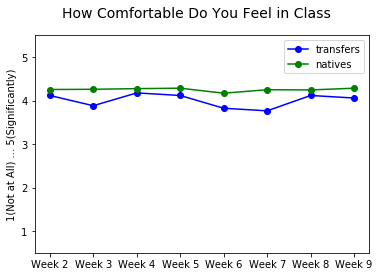

In [164]:
fig = DivergingGraphPlot(transfer, native, label, graphTitle, X_title, Y_title)
fig.show()

X_label = ""
Y_label = "1(Not at All) ... 5(Significantly)"
x_label = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
graphLabel = "How Comfortable Do You Feel in Class"
df = plotLineGraph(transfer, native, label, graphLabel, X_label, Y_label, x_label, x)
print(df)

<h3>Supported in Class:</h3>

In [165]:
category = "Reflecting.on.your.experiences.over.the.past.week..to.what.extent.do.you.agree.with.the.following.statements..I.feel.supported.in.this.class.."
label = "Supported "
graphTitle = "How Supported Do You Feel in Class"
X_title = "Percentage"
Y_title = "Student Type"
x = 8
scale1 = "1 (Not at all)"
scale5 = "5 (Completely)"
data = scaled_categories(reflections, category, label, x, scale1, scale5)
transfer = data['transfer']
native = data['native']

     Week  Transfer Mean  Native Mean  Difference  p-value (t-test)  \
0  Week 2       4.235294        4.275   -0.039706          0.850399   
1  Week 3       4.117647        4.240   -0.122353          0.554954   
2  Week 4       4.176471        4.235   -0.058529          0.803753   
3  Week 5       4.117647        4.285   -0.167353          0.432440   
4  Week 6       4.117647        4.245   -0.127353          0.591133   
5  Week 7       4.117647        4.290   -0.172353          0.447690   
6  Week 8       4.411765        4.285    0.126765          0.605999   
7  Week 9       4.176471        4.325   -0.148529          0.543136   

   p-value (u-test)  Test Statistic (t-test)  Test Statistic (u-test)  
0          0.393073                -0.188837                   1637.5  
1          0.320414                -0.591280                   1592.0  
2          0.290030                -0.248800                   1573.5  
3          0.275331                -0.786501                   1563.5  


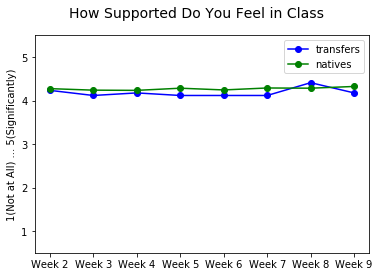

In [166]:
fig = DivergingGraphPlot(transfer, native, label, graphTitle, X_title, Y_title)
fig.show()

X_label = ""
Y_label = "1(Not at All) ... 5(Significantly)"
x_label = ["Week 2", "Week 3", "Week 4", "Week 5", "Week 6", "Week 7", "Week 8", "Week 9"]
graphLabel = "How Supported Do You Feel in Class"
df = plotLineGraph(transfer, native, label, graphLabel, X_label, Y_label, x_label, x)
print(df)